In [1]:
import pandas as pd
pred_data = pd.read_csv(r'C:\Users\parul.kakade\Documents\NIFTY_Prediction\6.SVM\predictions.csv')
pred_data['Predicted'].value_counts()

Predicted
0    389
1    150
Name: count, dtype: int64

In [2]:
pred_data

,Date,Actual,Predicted
0,2023-01-04,0,0
1,2023-01-05,0,0
2,2023-01-06,0,0
3,2023-01-09,1,1
4,2023-01-10,0,0
...,...,...,...
534,2025-05-23,1,1
535,2025-05-26,1,1
536,2025-05-28,0,0
537,2025-05-29,0,0


In [3]:
fut_data = pd.read_csv(r'C:\Users\parul.kakade\Documents\NIFTY_Prediction\6.SVM\Data\niftyCurrent.csv')
fut_data

,date,time,open,high,low,close,volume,open_interest,contract,underlying
0,1/2/2023,9:16:00,18209.00,18220.00,18186.80,18213.65,124350,10637550,NIFTY25JAN23FUT,NIFTY
1,1/2/2023,9:17:00,18215.95,18224.85,18208.30,18210.00,55650,10637550,NIFTY25JAN23FUT,NIFTY
2,1/2/2023,9:18:00,18210.30,18213.70,18197.80,18212.05,41100,10677800,NIFTY25JAN23FUT,NIFTY
3,1/2/2023,9:19:00,18212.90,18213.65,18196.55,18204.00,37600,10677800,NIFTY25JAN23FUT,NIFTY
4,1/2/2023,9:20:00,18205.85,18208.50,18188.50,18195.15,39400,10677800,NIFTY25JAN23FUT,NIFTY
...,...,...,...,...,...,...,...,...,...,...
210783,5/29/2025,15:26:59,24831.20,24835.00,24831.20,24832.70,12975,4737450,NIFTY29MAY25FUT,NIFTY
210784,5/29/2025,15:27:59,24832.70,24839.00,24832.70,24835.00,20175,4737450,NIFTY29MAY25FUT,NIFTY
210785,5/29/2025,15:28:59,24835.00,24839.40,24835.00,24835.00,19800,4706775,NIFTY29MAY25FUT,NIFTY
210786,5/29/2025,15:29:59,24834.10,24835.00,24831.80,24831.80,16350,4706775,NIFTY29MAY25FUT,NIFTY


In [4]:
print(fut_data.head(3))

       date     time      open      high      low     close  volume  \
0  1/2/2023  9:16:00  18209.00  18220.00  18186.8  18213.65  124350   
1  1/2/2023  9:17:00  18215.95  18224.85  18208.3  18210.00   55650   
2  1/2/2023  9:18:00  18210.30  18213.70  18197.8  18212.05   41100   

   open_interest         contract underlying  
0       10637550  NIFTY25JAN23FUT      NIFTY  
1       10637550  NIFTY25JAN23FUT      NIFTY  
2       10677800  NIFTY25JAN23FUT      NIFTY  


In [ ]:
import pandas as pd

def backtest_intraday(fut_data, predictions_df, lot_size=50):
    fut_data['datetime'] = pd.to_datetime(fut_data['date'] + ' ' + fut_data['time'])
    fut_data['date_only'] = fut_data['datetime'].dt.date
    results = []
    for dt, pred in zip(predictions_df['Date'], predictions_df['Predicted']):
        trade_date = pd.to_datetime(dt).date()
        day_data = fut_data[fut_data['date_only'] == trade_date]
        if day_data.empty:
            continue
        if pred == 1:
            day_data['time_obj'] = pd.to_datetime(day_data['time']).dt.time
            entry_candidates = day_data[
                (day_data['time_obj'].apply(lambda t: t.hour == 9 and t.minute == 16))
            ]

            if not entry_candidates.empty:
                entry_row = entry_candidates.iloc[[0]]
            else:
                print(f"No 09:16 data for {trade_date}, skipping trade")
                continue  
            exit_candidates = day_data[
                (day_data['time_obj'].apply(lambda t: t.hour == 15 and t.minute == 15))
            ]
        
            if not exit_candidates.empty:
                exit_row = exit_candidates.iloc[[-1]]
            else:
                print(f"No 15:15 data for {trade_date}, skipping trade")
                continue  
            if not entry_row.empty and not exit_row.empty:
                entry_price = entry_row['close'].iloc[0]
                exit_price = exit_row['close'].iloc[0]
                pnl = round((exit_price - entry_price) * lot_size, 2)
                results.append([trade_date, entry_price, exit_price, pnl])
            else:
                print(f"Data not available for date {trade_date}")
    results_df = pd.DataFrame(results, columns=['Date', 'Entry', 'Exit', 'PnL'])
    results_df['Cumulative_PnL'] = round(results_df['PnL'].cumsum(), 2)
    results_df.dropna(inplace=True)
    return results_df
bt_results = backtest_intraday(fut_data, pred_data, lot_size=75)
print(bt_results)

In [6]:
bt_results

,Date,Entry,Exit,PnL,Cumulative_PnL
0,2023-01-09,18037.1,18177.35,10518.75,10518.75
1,2023-01-13,17896.7,18025.00,9622.50,20141.25
2,2023-01-18,18087.7,18188.35,7548.75,27690.00
3,2023-01-30,17555.9,17744.35,14133.75,41823.75
4,2023-02-02,17589.6,17680.95,6851.25,48675.00
...,...,...,...,...,...
137,2025-05-09,24106.0,24060.50,-3412.50,1453635.00
138,2025-05-12,24605.3,25045.00,32977.50,1486612.50
139,2025-05-15,24708.4,25060.00,26370.00,1512982.50
140,2025-05-23,24665.6,24880.60,16125.00,1529107.50


In [7]:
total_trades = len(bt_results)
winning_trades = (bt_results['PnL'] > 0).sum()
win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0.0

print(f" Total Trades: {total_trades}")
print(f" Winning Trades: {winning_trades}")
print(f" Win Rate: {win_rate:.2f}%")

 Total Trades: 142
 Winning Trades: 138
 Win Rate: 97.18%


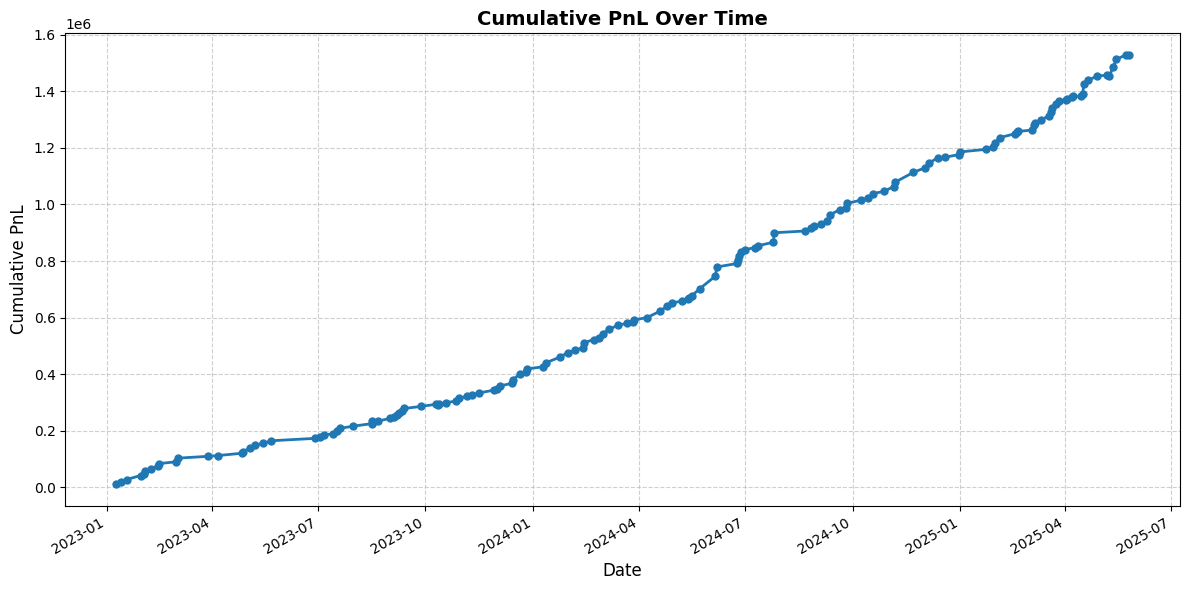

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(bt_results['Date'], bt_results['Cumulative_PnL'], marker='o', linewidth=2, markersize=5)

plt.title("Cumulative PnL Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative PnL", fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()


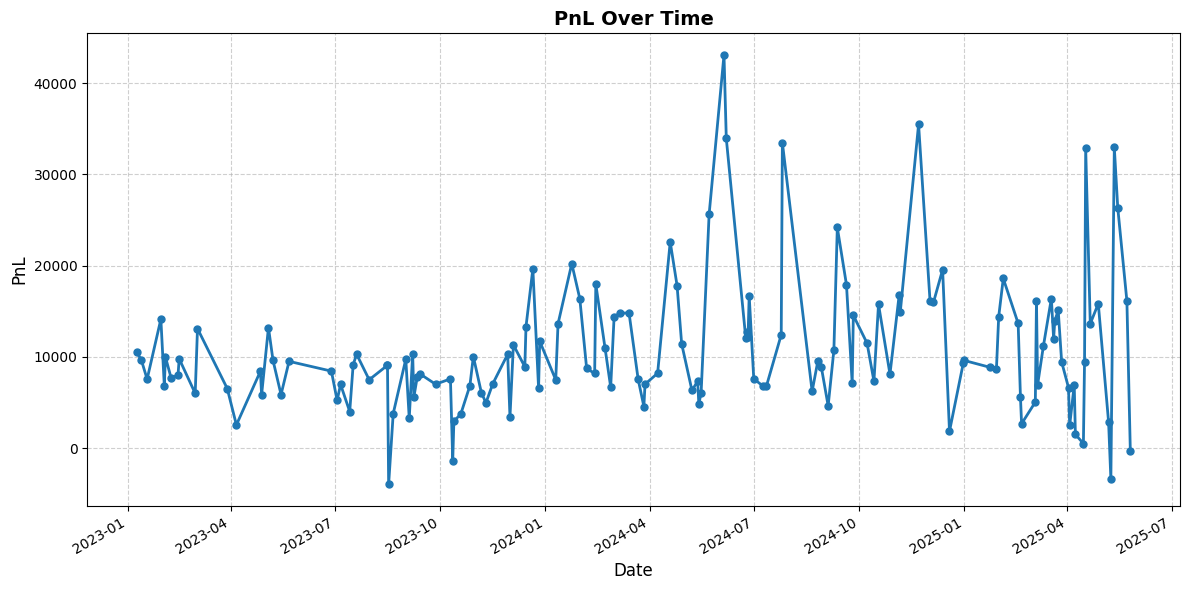

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(bt_results['Date'], bt_results['PnL'], marker='o', linewidth=2, markersize=5)

plt.title("PnL Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("PnL", fontsize=12)

plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()


In [26]:
import pandas as pd
pred_data = pd.read_csv(r'C:\Users\parul.kakade\Documents\NIFTY_Prediction\6.SVM\outsample_pred.csv')
print(pred_data['Predicted'].value_counts())
fut_dat = pd.read_csv(r'C:\Users\parul.kakade\Documents\NIFTY_Prediction\6.SVM\Data\niftyCurrent.csv')
fut_dat['date'] = pd.to_datetime(fut_data['date'])
fut_data = fut_dat[fut_dat['date']>'1/1/2025']


Predicted
0    61
1    29
Name: count, dtype: int64


In [28]:
import pandas as pd

def backtest_intraday(fut_data, predictions_df, lot_size=50):
    fut_data['datetime'] = fut_data['date'] + pd.to_timedelta(fut_data['time'])
    fut_data['date_only'] = fut_data['datetime'].dt.date
    results = []
    for dt, pred in zip(predictions_df['Date'], predictions_df['Predicted']):
        trade_date = pd.to_datetime(dt).date()
        day_data = fut_data[fut_data['date_only'] == trade_date]
        if day_data.empty:
            continue
        if pred == 1:
            day_data['time_obj'] = pd.to_datetime(day_data['time']).dt.time
            entry_candidates = day_data[
                (day_data['time_obj'].apply(lambda t: t.hour == 9 and t.minute == 16))
            ]

            if not entry_candidates.empty:
                entry_row = entry_candidates.iloc[[0]]
            else:
                print(f"No 09:16 data for {trade_date}, skipping trade")
                continue  
            exit_candidates = day_data[
                (day_data['time_obj'].apply(lambda t: t.hour == 15 and t.minute == 15))
            ]
        
            if not exit_candidates.empty:
                exit_row = exit_candidates.iloc[[-1]]
            else:
                print(f"No 15:15 data for {trade_date}, skipping trade")
                continue  
            if not entry_row.empty and not exit_row.empty:
                entry_price = entry_row['close'].iloc[0]
                exit_price = exit_row['close'].iloc[0]
                pnl = round((exit_price - entry_price) * lot_size, 2)
                results.append([trade_date, entry_price, exit_price, pnl])
            else:
                print(f"Data not available for date {trade_date}")
    results_df = pd.DataFrame(results, columns=['Date', 'Entry', 'Exit', 'PnL'])
    results_df['Cumulative_PnL'] = round(results_df['PnL'].cumsum(), 2)
    results_df.dropna(inplace=True)
    return results_df
bt_results = backtest_intraday(fut_data, pred_data, lot_size=75)
print(bt_results)

C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_21744\2555244786.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_21744\2555244786.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_21744\2555244786.py:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\pa

          Date     Entry      Exit       PnL  Cumulative_PnL
0   2025-01-06  24119.70  23689.90 -32235.00       -32235.00
1   2025-01-08  23765.15  23804.00   2913.75       -29321.25
2   2025-02-01  23610.00  23551.75  -4368.75       -33690.00
3   2025-02-04  23545.50  23793.35  18588.75       -15101.25
4   2025-03-05  22222.95  22438.15  16140.00         1038.75
5   2025-03-07  22585.00  22652.90   5092.50         6131.25
6   2025-03-10  22622.00  22525.30  -7252.50        -1121.25
7   2025-03-11  22402.50  22551.00  11137.50        10016.25
8   2025-03-12  22603.00  22532.10  -5317.50         4698.75
9   2025-03-13  22544.30  22447.25  -7278.75        -2580.00
10  2025-03-26  23692.85  23539.95 -11467.50       -14047.50
11  2025-04-03  23292.00  23325.00   2475.00       -11572.50
12  2025-04-15  23326.30  23332.80    487.50       -11085.00
13  2025-04-16  23297.90  23424.10   9465.00        -1620.00
14  2025-04-23  24309.20  24302.00   -540.00        -2160.00
15  2025-04-25  24479.10

C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_21744\2555244786.py:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_21744\2555244786.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_21744\2555244786.py:13: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_21744\2555244786.py:13: SettingWithCopyWarning:


A value is t

In [29]:
total_trades = len(bt_results)
winning_trades = (bt_results['PnL'] > 0).sum()
win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0.0

print(f" Total Trades: {total_trades}")
print(f" Winning Trades: {winning_trades}")
print(f" Win Rate: {win_rate:.2f}%")

 Total Trades: 28
 Winning Trades: 13
 Win Rate: 46.43%
